In [1]:
import itertools
import marsilea as ma
from pyhere import here
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import scienceplots
import matplotlib.pyplot as plt
from config import GENCODE_FPATH
from utils import get_pdf_dimensions_in_cm

# Setup

Number of codons: 61


In [2]:
mutations_everything = np.load(here('data', 'results', 'motifs', 'raw_bms', 'motifswAF_addStall_1000.npz'), allow_pickle=True)['mutations_everything'].item()
keys = list(mutations_everything.keys())
print(keys)

[('ENSMUSG00000024535.15', 'ENSMUST00000025417.8', 59, '[41 25  0 34 54 15  2 31 54 42  0 54 23 48 32 47 47 32 62 39 48]', 'CTRL', 0.627164363861084), ('ENSMUSG00000025340.14', 'ENSMUST00000119797.7', 148, '[10 22 34  3  8 62 32 48 54 17  0 35 11  3  7 21 23 48 56  7 41]', 'CTRL', 0.34909552335739136), ('ENSMUSG00000041712.7', 'ENSMUST00000046404.7', 107, '[ 0  2 23 48 30  0 20 21 41 50  0 24  3 52  1 25 30  1  3 18  1]', 'CTRL', 0.04427771270275116), ('ENSMUSG00000005374.13', 'ENSMUST00000153183.7', 106, '[49 50 46  9 54 45  6 31 14  9  0 49 22 37 35 47 51 34 46 14  7]', 'CTRL', 0.2138485610485077), ('ENSMUSG00000020708.12', 'ENSMUST00000021049.8', 45, '[39 35 56 35 15  1 51 39  1 56  0 53 46 39 23 47 51 51 39 35 39]', 'CTRL', 0.26157933473587036), ('ENSMUSG00000020692.14', 'ENSMUST00000103213.9', 160, '[37 14  4 26 31 26 40 49 62  3  0 39 58 24 62 30  3  1 62 35 53]', 'CTRL', 0.14311139285564423), ('ENSMUSG00000025139.14', 'ENSMUST00000001950.11', 250, '[45 25 55 37 48 58 35 12 63  2

In [3]:
motif_str = []
motif_len = []
condition = []
perc_increase = []
orig_density_list = []
new_density_list = []

for k in tqdm(keys):
    # print(k)
    start = k[2]
    orig_density = k[5]
    # print(mutations_everything[k])
    for mo in mutations_everything[k]:
        # print(mo, len(mo))
        condition.append(k[4])
        new_density = mutations_everything[k][mo]
        orig_density_list.append(orig_density)
        new_density_list.append(new_density)
        # print(orig_density, new_density, (new_density-orig_density)/orig_density)
        try:
            perc_increase.append(np.abs((new_density-orig_density)/orig_density))
        except:
            perc_increase.append(0)
        # print(orig_density, new_density)
        motif_len.append(int(len(mo)/2))
        motif_sample_dict = {}
        for i in range(0, len(mo), 2):
            # print(start-mo[i], mo[i+1])
            motif_sample_dict[mo[i] - (start+10)] = mo[i+1]
        # sort the dictionary in ascending order of the keys
        motif_sample_dict = dict(sorted(motif_sample_dict.items()))
        motif_str_sample = ''
        # print(motif_sample_dict)
        for k1, v1 in motif_sample_dict.items():
            motif_str_sample += str(k1) + '_' + str(v1) + '_'
        # print(motif_str_sample)
        motif_str.append(motif_str_sample)

  0%|          | 0/6000 [00:00<?, ?it/s]

In [4]:
# make a dataframe
df = pd.DataFrame({'motif': motif_str, 'motif_len': motif_len, 'perc_increase': perc_increase, 'condition': condition, 'orig_density': orig_density_list, 'new_density': new_density_list})
df

,motif,motif_len,perc_increase,condition,orig_density,new_density
0,-2_62_,1,0.610435,CTRL,0.627164,1.010007
1,-2_59_,1,0.601008,CTRL,0.627164,1.004095
2,-2_63_,1,0.576893,CTRL,0.627164,0.988971
3,-2_60_,1,0.529923,CTRL,0.627164,0.959513
4,2_52_,1,0.461877,CTRL,0.627164,0.916837
...,...,...,...,...,...,...
929995,-3_53_-1_54_3_60_,3,14.908668,VAL,0.025892,0.411908
929996,-3_53_-1_53_3_60_,3,14.299934,VAL,0.025892,0.396147
929997,-3_53_-2_54_3_60_,3,13.856807,VAL,0.025892,0.384674
929998,-3_53_-2_53_3_60_,3,12.606852,VAL,0.025892,0.352310


# Create Motif Positional Heatmap 

In [5]:
id_to_codon = {str(idx):''.join(el) for idx, el in enumerate(itertools.product(['A', 'T', 'C', 'G'], repeat=3))}
codon_to_id = {v:k for k,v in id_to_codon.items()}
id_to_codon['X'] = '[SKIP]'

# Function to fill missing integers with zeros
def create_exp_motif(lst):
    
    pos = lst['positions']
    motif_codons = iter(lst['motif_codons'])
    
    # Create a range from the minimum to the maximum value in the list
    full_range = range(min(pos), max(pos) + 1)
    # Replace missing integers with 0
    return [next(motif_codons) if i in pos else 'X' for i in full_range]

Define filled motifs and their starting positions

In [6]:
filled_motifs_df = (df
    .assign(motif_exp=lambda df: df.motif.str[:-1].str.split('_'))
    .assign(positions=lambda df: df.motif_exp.apply(lambda lst: list(map(int,lst[0::2]))))
    .assign(motif_codons=lambda df: df.motif_exp.apply(lambda lst: lst[1::2]))
    .assign(filled_motif_codons=lambda df: df.apply(create_exp_motif, axis=1))
    .assign(start_pos=lambda df: df.positions.apply(lambda lst: int(lst[0])))
    .assign(MAAPE=lambda df: df.apply(lambda row: 100*np.arctan(np.abs((row.orig_density - row.new_density) / (row.orig_density + 1e-9))), axis=1))
    .drop(columns=['motif', 'motif_len', 'perc_increase', 'orig_density', 'new_density', 'motif_exp', 'positions', 'motif_codons'])
    .assign(motif_key=lambda df: df.filled_motif_codons.astype(str))
    .groupby(['condition', 'motif_key'])
    .agg(dict(start_pos=lambda x: list(x), MAAPE='mean', filled_motif_codons='first'))
    .reset_index()
    .drop(columns=['motif_key'])
    )
filled_motifs_df

,condition,start_pos,MAAPE,filled_motif_codons
0,CTRL,"[-6, -5, -6, -8, -6, -5, -5, -5, -6, -6, -6]",109.773602,"[0, 0, 0]"
1,CTRL,"[-3, -4, -6]",120.688572,"[0, 0, 11]"
2,CTRL,"[-5, -5, -6, -5, -5, -4, -5, -4, -6, -6, -6, -6]",121.306893,"[0, 0, 12]"
3,CTRL,"[-5, -5, -6, -6, -5, -5, -5, -5]",133.011682,"[0, 0, 15]"
4,CTRL,"[-4, -4]",125.844214,"[0, 0, 2]"
...,...,...,...,...
238245,VAL,[-7],139.075060,"[9, X, X, X, 52, 54]"
238246,VAL,[-7],139.542514,"[9, X, X, X, 53, 54]"
238247,VAL,"[-7, -7, -6, -6]",143.770898,"[9, X, X, X, 54, 53]"
238248,VAL,"[-7, -7]",140.129511,"[9, X, X, X, 54, 54]"


Aggregate filled motifs

In [12]:
exclude_conditions = ['LEU_ILE', 'LEU_ILE_VAL']
agg_filled_motifs_df = (filled_motifs_df
 .assign(freq=lambda df: df.start_pos.apply(lambda x: len(x)))
 .groupby('condition', group_keys=False)
 .apply(lambda x: x.nlargest(10, 'freq'))
 .assign(filled_motif_codons=lambda df: df.filled_motif_codons.apply(lambda x: ' '.join([id_to_codon[key] for key in x])))
 .assign(bincount=lambda df: df.start_pos.apply(lambda x: np.bincount(np.array(x)+10, minlength=16)/len(x))))
agg_filled_motifs_df = agg_filled_motifs_df.query('not condition.isin(@exclude_conditions)')

In [13]:
result_df2 = (df
 .assign(motif_exp=lambda df: df.motif.str[:-1].str.split('_'))
 .assign(positions=lambda df: df.motif_exp.apply(lambda lst: list(map(int,lst[0::2]))))
 .assign(motif_codons=lambda df: df.motif_exp.apply(lambda lst: lst[1::2]))
 .assign(filled_motif_codons=lambda df: df.apply(create_exp_motif, axis=1))
 .assign(start_pos=lambda df: df.positions.apply(lambda lst: int(lst[0])))
 .assign(MAAPE=lambda df: df.apply(lambda row: 100*np.arctan(np.abs((row.orig_density - row.new_density) / (row.orig_density + 1e-9))), axis=1))
 .drop(columns=['motif', 'motif_len', 'perc_increase', 'orig_density', 'new_density', 'motif_exp', 'positions', 'motif_codons'])
 .assign(motif_key=lambda df: df.filled_motif_codons.astype(str))
 .groupby(['condition', 'motif_key', 'start_pos'])
 .agg(dict(MAAPE='mean', filled_motif_codons='first'))
)
result_df2.head()

MAAPE filled_motif_codons
condition motif_key        start_pos                                
CTRL      ['0', '0', '0']  -8         118.956399           [0, 0, 0]
                           -6         104.457392           [0, 0, 0]
                           -5         115.452218           [0, 0, 0]
          ['0', '0', '11'] -6          95.336601          [0, 0, 11]
                           -4         151.673213          [0, 0, 11]

In [14]:
maape = result_df2.reset_index().pivot(index=['condition', 'motif_key'],columns='start_pos',values='MAAPE').iloc[agg_filled_motifs_df.index].fillna(0).values
maape

array([[  0.        ,   0.        ,   0.        ,   0.        ,
         35.15262901,  53.88790591,  86.19813506,  88.32645516,
         83.83309087, 142.2395214 ,  62.66243803,  74.29849287,
         86.21880384,  84.71957759,  59.43903446,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         93.75572317,  99.89063383, 108.83942406, 116.65787578,
        115.12503912,  95.45619559, 104.23632239, 111.8046008 ,
        119.69598861, 119.93430367, 114.94985715,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        , 106.12404119,  92.40218465, 111.03127412,
        109.090415  ,  85.25941157,  85.71738609,  92.91529426,
         96.3727278 , 103.17819866,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         91.20190261, 144.00961569, 108.11229875, 110.91039697,
        109.46847224,  78.50441438,  89.45787046, 102.38550013,
        108.01410776, 111.2894144 ,  

In [15]:
pos_freq = np.stack(agg_filled_motifs_df.bincount.values)

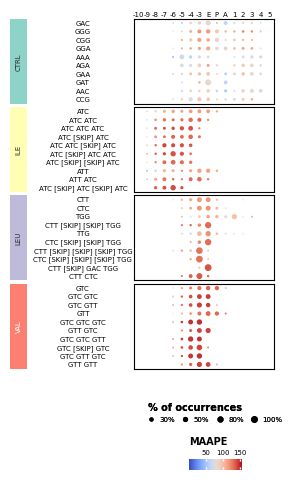

In [ ]:
from matplotlib.ticker import FuncFormatter, FixedLocator


SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE, title_fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('font', family='arial')
plt.rcParams['svg.fonttype'] = 'none'


cmap = plt.get_cmap('Set3')
colors = np.array(cmap.colors)

fmt = FuncFormatter(lambda x, _: f"{x:.0%}")

cells_proportion = ma.plotter.SizedMesh(
    pos_freq,
    color=maape,
    sizes=(0, 15),
    size_legend_kws=dict(title="% of occurrences", show_at=[0.3, 0.5, 0.8, 1], fmt=fmt, ncols=4),
    color_legend_kws=dict(title='MAAPE', orientation='horizontal', height=1.5),
)
h = ma.base.ClusterBoard(np.zeros(pos_freq.shape), width=1.4, height=3.5)
h.add_layer(cells_proportion)
h.add_left(ma.plotter.Labels(agg_filled_motifs_df.filled_motif_codons, align="center"))
h.group_rows(agg_filled_motifs_df.condition)
h.add_left(ma.plotter.Chunk(agg_filled_motifs_df.condition.unique(), fill_colors=colors[:agg_filled_motifs_df.condition.unique().shape[0]]), pad=0.05)
h.add_top(ma.plotter.Labels(list(range(-10, -2))+['E','P','A']+list(range(1,6)), align="center", rotation=0))
h.add_legends("bottom", align_stacks="center", align_legends="center", stack_by='col', pad=0.2)
h.render()
plt.savefig(here('data', 'results', 'figures', f'filled_motif_pos.pdf'), dpi=600, bbox_inches='tight', pad_inches=0.0)

In [86]:
get_pdf_dimensions_in_cm(here('data', 'results', 'figures', f'filled_motif_pos.pdf'))

(8.34848611111111, 15.852841145833331)

# Create Codon Stats on Motifs

In [18]:
# global variables
id_to_codon = {idx:''.join(el) for idx, el in enumerate(itertools.product(['A', 'T', 'C', 'G'], repeat=3))}
codon_to_id = {v:k for k,v in id_to_codon.items()}

stop_codons = ['TAA', 'TAG', 'TGA']

codonid_list = []

for i in range(64):
    codon = id_to_codon[i]
    if codon not in stop_codons:
        codonid_list.append(i)

print('Number of codons:', len(codonid_list))

condition_dict_values = {64: 'CTRL', 65: 'ILE', 66: 'LEU', 67: 'LEU_ILE', 68: 'LEU_ILE_VAL', 69: 'VAL'}
condition_dict = {v: k for k, v in condition_dict_values.items()}

Number of codons: 61


In [19]:
pos = []
for i in range(len(motif_str)):
    x = motif_str[i].split('_')[:-1]
    x = [int(el) for el in x]
    for j in range(0, len(x), 2):
        pos.append(x[j])

In [20]:
# condition wise get the unique motifs and get their percentage counts 
condition_wise_dfs = {}

for c in df['condition'].unique():
    df_c = df[df['condition'] == c]

    # retain only one row per unique motif
    df_c = df_c['motif'].value_counts(normalize=True).reset_index()
    df_c.columns = ['motif', 'perc']

    c_list_fin = [[] for _ in range(21)]

    for m in tqdm(df_c['motif']):
        m_s = m.split('_')[:-1]
        for i in range(0, len(m_s), 2):
            # print(id_to_codon[int(m_s[i+1])], int(m_s[i])+10)
            c_list_fin[int(m_s[i])+10].append(id_to_codon[int(m_s[i+1])])

        # other codons that are not in the motif, put - 
        pos_motif = [int(x) for x in m_s[::2]]
        for i in range(-10, 11):
            if i not in pos_motif:
                c_list_fin[i+10].append('-')

    # add the codons in the motif to the df
    for i in range(-10, 11):
        df_c['codon_'+str(i)] = c_list_fin[i+10]

    # rename the codon columns
    df_c.columns = ['motif', 'perc_counts'] + ['-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', 'E', 'P', 'A', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

    condition_wise_dfs[c] = df_c

  0%|          | 0/97438 [00:00<?, ?it/s]

  0%|          | 0/45942 [00:00<?, ?it/s]

  0%|          | 0/59144 [00:00<?, ?it/s]

  0%|          | 0/37895 [00:00<?, ?it/s]

  0%|          | 0/21837 [00:00<?, ?it/s]

  0%|          | 0/23181 [00:00<?, ?it/s]

/tmp/ipykernel_3540539/2966597477.py:36: RuntimeWarning: invalid value encountered in scalar divide
  df_c_mat_perc[j, i] = (np.sum(codon_counts == id_to_codon[j])/num_non_dash)*100
/tmp/ipykernel_3540539/2966597477.py:36: RuntimeWarning: invalid value encountered in scalar divide
  df_c_mat_perc[j, i] = (np.sum(codon_counts == id_to_codon[j])/num_non_dash)*100


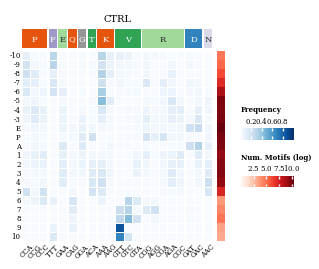

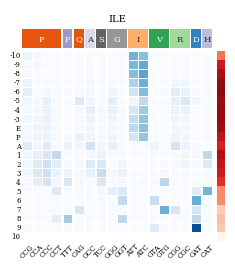

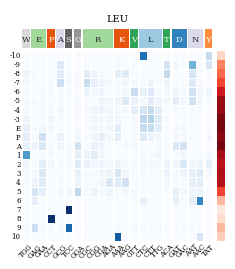

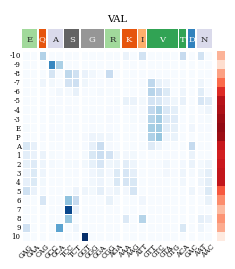

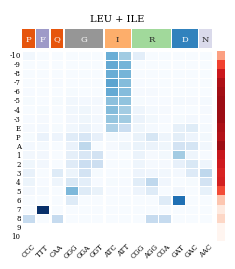

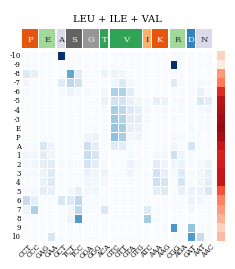

In [22]:
colors_full = plt.cm.tab20c(np.linspace(0, 1, 64))
colors_aa = np.array(colors_full).repeat(2,0)
np.random.seed(42)
np.random.shuffle(colors_aa)
max_motif_val = 28383

SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

with plt.style.context(['science','nature','grid','bright','no-latex']):
    plt.rc('font', size=SMALL_SIZE) 
    plt.rc('legend', fontsize=SMALL_SIZE, title_fontsize=SMALL_SIZE)
    plt.rc('xtick', labelsize=SMALL_SIZE)
    plt.rc('ytick', labelsize=SMALL_SIZE)

    # for c in df['condition'].unique():
    for c in ['CTRL', 'ILE', 'LEU', 'VAL', 'LEU_ILE', 'LEU_ILE_VAL']:
        AA = ['Val', 'Ile', 'Leu', 'Lys', 'Asn', 'Thr', 'Arg', 'Ser', 'Met', 'Gln', 'His', 'Pro', 'Glu', 'Asp', 'Ala', 'Gly', 'Tyr', 'Cys', 'Trp', 'Phe', 'Stp']
        AA_1 = ['V', 'I', 'L', 'K', 'N', 'T', 'R', 'S', 'M', 'Q', 'H', 'P', 'E', 'D', 'A', 'G', 'Y', 'C', 'W', 'F', 'S']
        aa_3_1 = {AA[i]: AA_1[i] for i in range(len(AA))}

        # for c in df['condition'].unique():
        df_c = condition_wise_dfs[c]
        df_c = df_c.drop(columns=['motif', 'perc_counts'])
        df_c_mat = df_c.to_numpy()

        # convert this matrix into a percentage occurrence matrix without the '-' codon
        df_c_mat_perc = np.zeros((64, 21))
        for i in range(21):
            # get the percentage counts of the 64 codons at this position
            codon_counts = df_c_mat[:, i]
            num_non_dash = np.sum(codon_counts != '-')
            # get counts for each codon
            for j in range(64):
                df_c_mat_perc[j, i] = (np.sum(codon_counts == id_to_codon[j])/num_non_dash)*100

        # replace nans with 0
        df_c_mat_perc = np.nan_to_num(df_c_mat_perc)

        stack_data = pd.DataFrame(df_c_mat_perc, index=[id_to_codon[i] for i in range(64)])

        # sort the data by rows 
        stack_data = stack_data.sort_values(by=stack_data.columns.tolist(), ascending=False)
        # make a heatmap
        # remove rows that have a sum less than the mean of the row sums
        stack_data_t = stack_data[stack_data.sum(axis=1) > stack_data.sum(axis=1).mean()]

        # normalize every column
        stack_data_thresh = stack_data_t/stack_data_t.sum(axis=0)
        h = ma.Heatmap(stack_data_thresh.T, linewidth=0.5, width=1.9, height=1.9, cmap='Blues', label='Frequency', vmin=0, vmax=1, cbar_kws=dict(orientation='horizontal', height=1.5))
        # add lables to x and y axis with chunk
        colors_set = [colors_full[codon_to_id[i]] for i in list(stack_data_thresh.index)]
        # only keep the amino acids for the codons
        genetic_code = pd.read_csv(GENCODE_FPATH, index_col=0).set_index('Codon')
        # add one letter amino acid code to the genetic code
        genetic_code['AminoAcid_1'] = [aa_3_1[i] for i in genetic_code['AminoAcid']]
        genetic_code = genetic_code.loc[stack_data_thresh.index]
        # h.add_top(ma.plotter.Chunk(list(stack_data_thresh.index), colors_set, fontsize=15), pad=0.025)
        # group the amino acids
        h.group_cols(group=genetic_code.AminoAcid_1, order=list(set(genetic_code.AminoAcid_1)), spacing=0.007)
        colors_aa_c = []
        for i in list(set(genetic_code.AminoAcid_1)): # index of the amino acid in AA
            colors_aa_c.append(colors_aa[AA_1.index(i)])
        h.add_top(ma.plotter.Chunk(list(set(genetic_code.AminoAcid_1)), colors_aa_c, fontsize=MEDIUM_SIZE), pad=0.025)
        h.add_bottom(ma.plotter.Labels(list(stack_data_thresh.index), fontsize=SMALL_SIZE, rotation=45), name='Codon')

        # add right barplot with the number of motifs 
        num_motifs_list = stack_data_t.sum(axis=0).values/100
        for i in range(21):
            codon_counts = df_c_mat[:, i]
            num_non_dash = np.sum(codon_counts != '-')
            num_motifs_list[i] = num_non_dash * num_motifs_list[i]

        # log the number of motifs
        num_motifs_list = np.log(num_motifs_list+1)

        # make a colormesh plot and add it to the right of the heatmap
        cm = ma.plotter.ColorMesh(num_motifs_list.reshape(1, -1), cmap='Reds', vmin=0, vmax=np.log(max_motif_val), cbar_kws=dict(orientation='horizontal', title='Num. Motifs (log)', height=1.5))
        h.add_right(cm, pad=0.05, size=0.075)

        # h.add_right(ma.plotter.Numbers(num_motifs_list, label='Num. Motifs', show_value = True), pad=0.1)

        c_text = c 
        if c == 'LEU_ILE':
            c_text = 'LEU + ILE'
        if c == 'LEU_ILE_VAL':
            c_text = 'LEU + ILE + VAL'
        h.add_title(c_text, fontsize=BIGGER_SIZE)

        pos_labels_list = ['-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', 'E', 'P', 'A', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

        h.add_left(ma.plotter.Labels(list(pos_labels_list), fontsize=SMALL_SIZE))
        if c == 'CTRL':
            h.add_legends(pad=0.025)
        h.render()

        plt.savefig(here('data', 'results', 'figures', f'motifswAF_addStall_1000_HeatMap_{c}.svg'), dpi=600, bbox_inches='tight', pad_inches=0.0)

In [94]:
c='CTRL'
get_pdf_dimensions_in_cm(here('data', 'results', 'figures', f'motifswAF_addStall_1000_HeatMap_{c}.pdf'))

(5.1138666666666674, 7.0074234375)